# Batch Reactor Example
## Ignition delay computation

In this example we will illustrate how to setup and use a constant volume batch reactor. This reactor will then be used to compute the ignition delay of a gas at any temperature and pressure

The reactor (system) is simply an insulated box.

In [1]:
from __future__ import division
from __future__ import print_function

import pandas as pd
import numpy as np

import cantera as ct
print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 2.3.0a3


### Define the gas
In this example we will choose n-heptane as the gas. So we use the 160 species mechanism by Seier et al. 2000, Proc. Comb. Inst

In [2]:
gas = ct.Solution('/Users/santosh1/chemicalMechanisms/nHeptane_llnl/seiser.cti')



**** WARNING ****
For species c7h15o-1, discontinuity in cp/R detected at Tmid = 1391
	Value computed using low-temperature polynomial:  53.0168
	Value computed using high-temperature polynomial: 52.748


**** WARNING ****
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767


### Define reactor conditions : temperature, pressure, fuel, stoichiometry

In [3]:
# Define the reactor temperature and pressure
reactorTemperature = 1000
reactorPressure = 101325.0

gas.TP = reactorTemperature, reactorPressure

# Define the fuel, oxidizer and set the stoichiometry
gas.set_equivalence_ratio(phi=1.0, fuel='nc7h16', oxidizer={'o2':1.0, 'n2':3.76})

# Create a batch reactor object and add it to a reactor network
# In this example, the batch reactor will be the only reactor
# in the network
r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
reactorNetwork = ct.ReactorNet([r])

# now initialize an empty data frame into which we store values
# for this list all the species and turn them into column names
nSpecies = gas.n_species
stateVariables = nSpecies + 3

stateVariableNames = []
for i in range(stateVariables):
    stateVariableNames.append(r.component_name(i))


timeHistory = pd.DataFrame(columns=['time'] + stateVariableNames)

### Define useful functions

In [4]:
def updateStateDataFrame(df, stateArray):
    """
    This function will be used to store all the state variable parameters
    as the reactor evolves over time. At every time-step we call on this 
    function to update the dataFrame
    """
    return df.append(pd.DataFrame([stateArray], columns=df.columns), ignore_index=True)

def ignitionDelay(df, specie):
    """
    This function computes the ignition delay from the occurence of the 
    peak 'OH' value.
    """
    return df[specie].argmax(), df.iloc[df[specie].argmax()]['time']

In [5]:
timeStep=1e-5
simulationEndTime=0.05
    
times = np.arange(0, simulationEndTime, timeStep)
print('Number of steps: {}'.format(times.shape[0]))

for t in times:    
    reactorNetwork.advance(t)
    timeHistory = updateStateDataFrame(timeHistory, np.append(t, reactorNetwork.get_state()))

index, tau = ignitionDelay(timeHistory, 'oh')
print('Computed Ignition Delay: {}'.format(tau))

Number of steps: 5000
Computed Ignition Delay: 0.03248


## Plot the result

In [6]:
import matplotlib.pylab as plt
%matplotlib notebook

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.style.use('ggplot')
plt.style.use('seaborn-pastel')

<IPython.core.display.Javascript object>


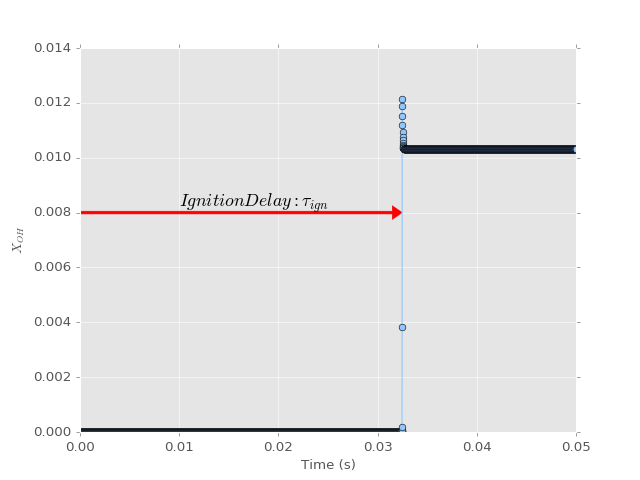

In [7]:
plt.plot(timeHistory['time'], timeHistory['oh'],'-o')
plt.xlabel('Time (s)')
plt.ylabel('$X_{OH}$')
plt.arrow(0, 0.008, tau, 0, width=0.0001, head_width=0.0005, 
          head_length=0.001, length_includes_head=True, color='r', shape='full')
plt.annotate(r'$Ignition Delay: \tau_{ign}$', xy=(0,0), xytext=(0.01, 0.0082), fontsize=16)

## Illustration : NTC behavior
One of the most common benchmarks of a reaction mechanism is its ability to reproduce the NTC behavior. This is done by computing and visualizing the ignition delay for a wide range of temperatures

### Compute ignition delays for a bunch of temperatures